
# EEG Preprocessing Pipeline: Quality Assessment & Filtering

## Overview
This notebook implements a comprehensive EEG preprocessing pipeline with two main phases:
1. **Quality Assessment** - Initial data inspection and quality metrics
2. **Filtering Pipeline** - Complete signal cleaning in one step
 
### Pipeline Architecture
```
RAW EEG → Quality Assessment → Filtering → Cleaned Data
        ↘ Quality Reports   ↘ Filter Reports
```

# PHASE 1: QUALITY ASSESSMENT

**Purpose**
- Understand data structure and file organization
- Assess initial data quality and identify issues
- Generate comprehensive quality reports
- Establish baseline for preprocessing decisions

## Step 1: Environment Setup & Directory Structure

In [7]:
#%% Cell 1: Import all required libraries

# %% Cell 1.1: Import all required libraries
import pandas as pd
import numpy as np
import mne
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ Environment setup complete")


# Cell 1.2: Create organized directory structure

print("📁 CREATING PREPROCESSING DIRECTORY STRUCTURE")
print("=" * 50)


def create_preprocessing_directory_structure():
    """
    Create organized directory structure for EEG preprocessing pipeline.
    
    Returns:
        Path: Main output directory path
    """
    output_path = Path('EEG_Preprocessing_Output')
    
    # Define comprehensive directory structure
    directories = [
        # Data processing directories
        'preprocessed_data/raw_cleaned',
        'preprocessed_data/ica_cleaned', 
        'preprocessed_data/epochs',
        'preprocessed_data/features',
        
        # Quality assessment directories
        'preprocessed_data/quality_reports',
        'preprocessed_data/visualizations',
        
        # Reporting directories
        'reports/individual_subjects',
        'reports/aggregate',
        'pipeline_logs'
    ]
    
    # Create all directories
    created_dirs = []
    for dir_path in directories:
        full_path = output_path / dir_path
        full_path.mkdir(parents=True, exist_ok=True)
        created_dirs.append(str(full_path))
        print(f"   ✅ Created: {dir_path}")
    
    print(f"📁 Directory structure created:")
    print(f"   Main output: {output_path}")
    print(f"   Total directories: {len(created_dirs)}")
    
    return output_path




# Create directory structure
output_path = create_preprocessing_directory_structure()



✅ Environment setup complete
📁 CREATING PREPROCESSING DIRECTORY STRUCTURE
   ✅ Created: preprocessed_data/raw_cleaned
   ✅ Created: preprocessed_data/ica_cleaned
   ✅ Created: preprocessed_data/epochs
   ✅ Created: preprocessed_data/features
   ✅ Created: preprocessed_data/quality_reports
   ✅ Created: preprocessed_data/visualizations
   ✅ Created: reports/individual_subjects
   ✅ Created: reports/aggregate
   ✅ Created: pipeline_logs
📁 Directory structure created:
   Main output: EEG_Preprocessing_Output
   Total directories: 9


## Step 2: Data Inventory Analysis

In [8]:
# %% Cell 2: Load and analyze EEG inventory


def load_and_analyze_inventory(inventory_path='EEG_Inventory/eeg_inventory_detailed.csv'):
    """
    Load and analyze the EEG inventory to understand data structure.
    
    Args:
        inventory_path (str): Path to inventory CSV file
        
    Returns:
        pd.DataFrame: Inventory dataframe with metadata
    """
    print("🔍 ANALYZING EEG INVENTORY")
    print("=" * 50)
    
    # Load inventory
    inventory_df = pd.read_csv(inventory_path)
    
    # Basic information
    print(f"📊 Inventory Overview:")
    print(f"   • Total files: {inventory_df.shape[0]}")
    print(f"   • Columns: {list(inventory_df.columns)}")
    
    # Data quality checks
    print(f"\n📈 Data Quality Checks:")
    print(f"   • Missing values: {inventory_df.isnull().sum().sum()}")
    print(f"   • Unique subjects: {inventory_df['subject_id'].nunique()}")
    print(f"   • Unique sessions: {inventory_df['session_id'].nunique()}")
    print(f"   • Task types: {inventory_df['task_type'].unique()}")
    
    # File existence verification
    if 'file_path' in inventory_df.columns:
        existing_files = inventory_df['file_path'].apply(os.path.exists).sum()
        print(f"   • Files accessible: {existing_files}/{len(inventory_df)}")
    
    print("\n📋 First 3 files:")
    print(inventory_df[['subject_id', 'session_id', 'task_type', 'filename']].head(3))
    
    return inventory_df

# Load inventory
inventory_df = load_and_analyze_inventory()

🔍 ANALYZING EEG INVENTORY
📊 Inventory Overview:
   • Total files: 419
   • Columns: ['subject_id', 'session_id', 'task_type', 'filename', 'file_path', 'file_size_mb', 'has_fdt_file']

📈 Data Quality Checks:
   • Missing values: 0
   • Unique subjects: 27
   • Unique sessions: 5
   • Task types: ['Pre-rehabilitation' 'Task-run' 'Post-rehabilitation']
   • Files accessible: 419/419

📋 First 3 files:
  subject_id session_id           task_type                  filename
0     sub-01      ses-1  Pre-rehabilitation  sub-01_pre_run-1_eeg.set
1     sub-01      ses-1  Pre-rehabilitation  sub-01_pre_run-2_eeg.set
2     sub-01      ses-1  Pre-rehabilitation  sub-01_pre_run-3_eeg.set


## Step 3: Single File Quality Assessment
## Load Sample EEG File

In [9]:
# %% Cell 3: Single File Quality Assessment

def load_sample_eeg_file(inventory_df, file_index=0):
    """
    Load a single EEG file for initial quality assessment.
    
    Args:
        inventory_df (pd.DataFrame): EEG inventory
        file_index (int): Index of file to load
        
    Returns:
        tuple: (raw EEG object, file metadata)
    """
    file_info = inventory_df.iloc[file_index]
    
    print(f"🔬 LOADING SAMPLE EEG FILE")
    print("=" * 50)
    print(f"   Subject: {file_info['subject_id']}")
    print(f"   Session: {file_info['session_id']}") 
    print(f"   Task: {file_info['task_type']}")
    print(f"   File: {file_info['filename']}")
    
    # Verify file exists
    if not os.path.exists(file_info['file_path']):
        raise FileNotFoundError(f"File not found: {file_info['file_path']}")
    
    # Load EEG data
    try:
        raw = mne.io.read_raw_eeglab(file_info['file_path'], preload=True)
        print("   ✅ EEG data loaded successfully")
        return raw, file_info
    except Exception as e:
        raise Exception(f"Error loading EEG data: {e}")

# Load sample file
raw, file_info = load_sample_eeg_file(inventory_df)

# Display basic info
print(f"\n📋 EEG Data Specifications:")
print(f"   • Channels: {len(raw.ch_names)}")
print(f"   • Sampling rate: {raw.info['sfreq']} Hz")
print(f"   • Duration: {raw.times[-1]:.1f} seconds")
print(f"   • Data shape: {raw.get_data().shape}")

🔬 LOADING SAMPLE EEG FILE
   Subject: sub-01
   Session: ses-1
   Task: Pre-rehabilitation
   File: sub-01_pre_run-1_eeg.set
   ✅ EEG data loaded successfully

📋 EEG Data Specifications:
   • Channels: 40
   • Sampling rate: 250.0 Hz
   • Duration: 200.1 seconds
   • Data shape: (40, 50020)


## Step 4: Comprehensive Quality Assessment

In [10]:
# %% Cell 4: Perform Comprehensive Quality Assessment
def perform_quality_assessment(raw, file_info):
    """
    Perform comprehensive quality assessment on EEG data.
    
    Args:
        raw: MNE Raw object
        file_info: File metadata dictionary
        
    Returns:
        dict: Comprehensive quality metrics
    """
    print("\n📊 PERFORMING COMPREHENSIVE QUALITY ASSESSMENT")
    print("=" * 50)
    
    # Get data and convert to microvolts
    data = raw.get_data()
    data_scaled = data * 1e6  # Convert to µV
    
    # Calculate quality metrics
    quality_metrics = {
        # Basic metadata
        'subject_id': file_info['subject_id'],
        'session_id': file_info['session_id'], 
        'task_type': file_info['task_type'],
        'original_filename': file_info['filename'],
        
        # Data specifications
        'n_channels': len(raw.ch_names),
        'sfreq': raw.info['sfreq'],
        'duration_seconds': raw.times[-1],
        'n_samples': raw.n_times,
        'channel_names': raw.ch_names,
        'bad_channels_initial': raw.info['bads'],
        
        # Quality metrics
        'data_range_min': float(np.min(data_scaled)),
        'data_range_max': float(np.max(data_scaled)),
        'global_mean': float(np.mean(data_scaled)),
        'global_std': float(np.std(data_scaled)),
        'channel_means': [float(x) for x in np.mean(data_scaled, axis=1)],
        'channel_stds': [float(x) for x in np.std(data_scaled, axis=1)],
        'max_channel_variance': float(np.max(np.var(data_scaled, axis=1))),
        'min_channel_variance': float(np.min(np.var(data_scaled, axis=1))),
        'signal_to_noise_ratio': float(np.mean(np.abs(data_scaled)) / np.std(data_scaled) if np.std(data_scaled) > 0 else 0)
    }
    
    # Print quality summary
    print(f"📈 Quality Summary:")
    print(f"   • Data range: {quality_metrics['data_range_min']:.1f} to {quality_metrics['data_range_max']:.1f} µV")
    print(f"   • Global STD: {quality_metrics['global_std']:.2f} µV")
    print(f"   • Channel variance: {quality_metrics['min_channel_variance']:.2f} to {quality_metrics['max_channel_variance']:.2f} µV²")
    print(f"   • SNR: {quality_metrics['signal_to_noise_ratio']:.2f}")
    
    # Quality warnings
    print(f"\n🔍 Quality Assessment:")
    if quality_metrics['global_std'] < 1:
        print("   ⚠️  Low variance - check data scaling")
    if len(quality_metrics['bad_channels_initial']) > 0:
        print(f"   ⚠️  Pre-marked bad channels: {quality_metrics['bad_channels_initial']}")
    if quality_metrics['max_channel_variance'] / quality_metrics['min_channel_variance'] > 100:
        print("   ⚠️  High channel variance ratio")
    
    print("   ✅ Data suitable for preprocessing")
    
    return quality_metrics, data_scaled

# Perform quality assessment
quality_metrics, data_scaled = perform_quality_assessment(raw, file_info)


📊 PERFORMING COMPREHENSIVE QUALITY ASSESSMENT
📈 Quality Summary:
   • Data range: -21.6 to 21.9 µV
   • Global STD: 2.98 µV
   • Channel variance: 2.74 to 17.13 µV²
   • SNR: 0.77

🔍 Quality Assessment:
   ✅ Data suitable for preprocessing


## Step 5: Quality Visualization


📈 GENERATING QUALITY VISUALIZATIONS
Effective window size : 8.192 (s)


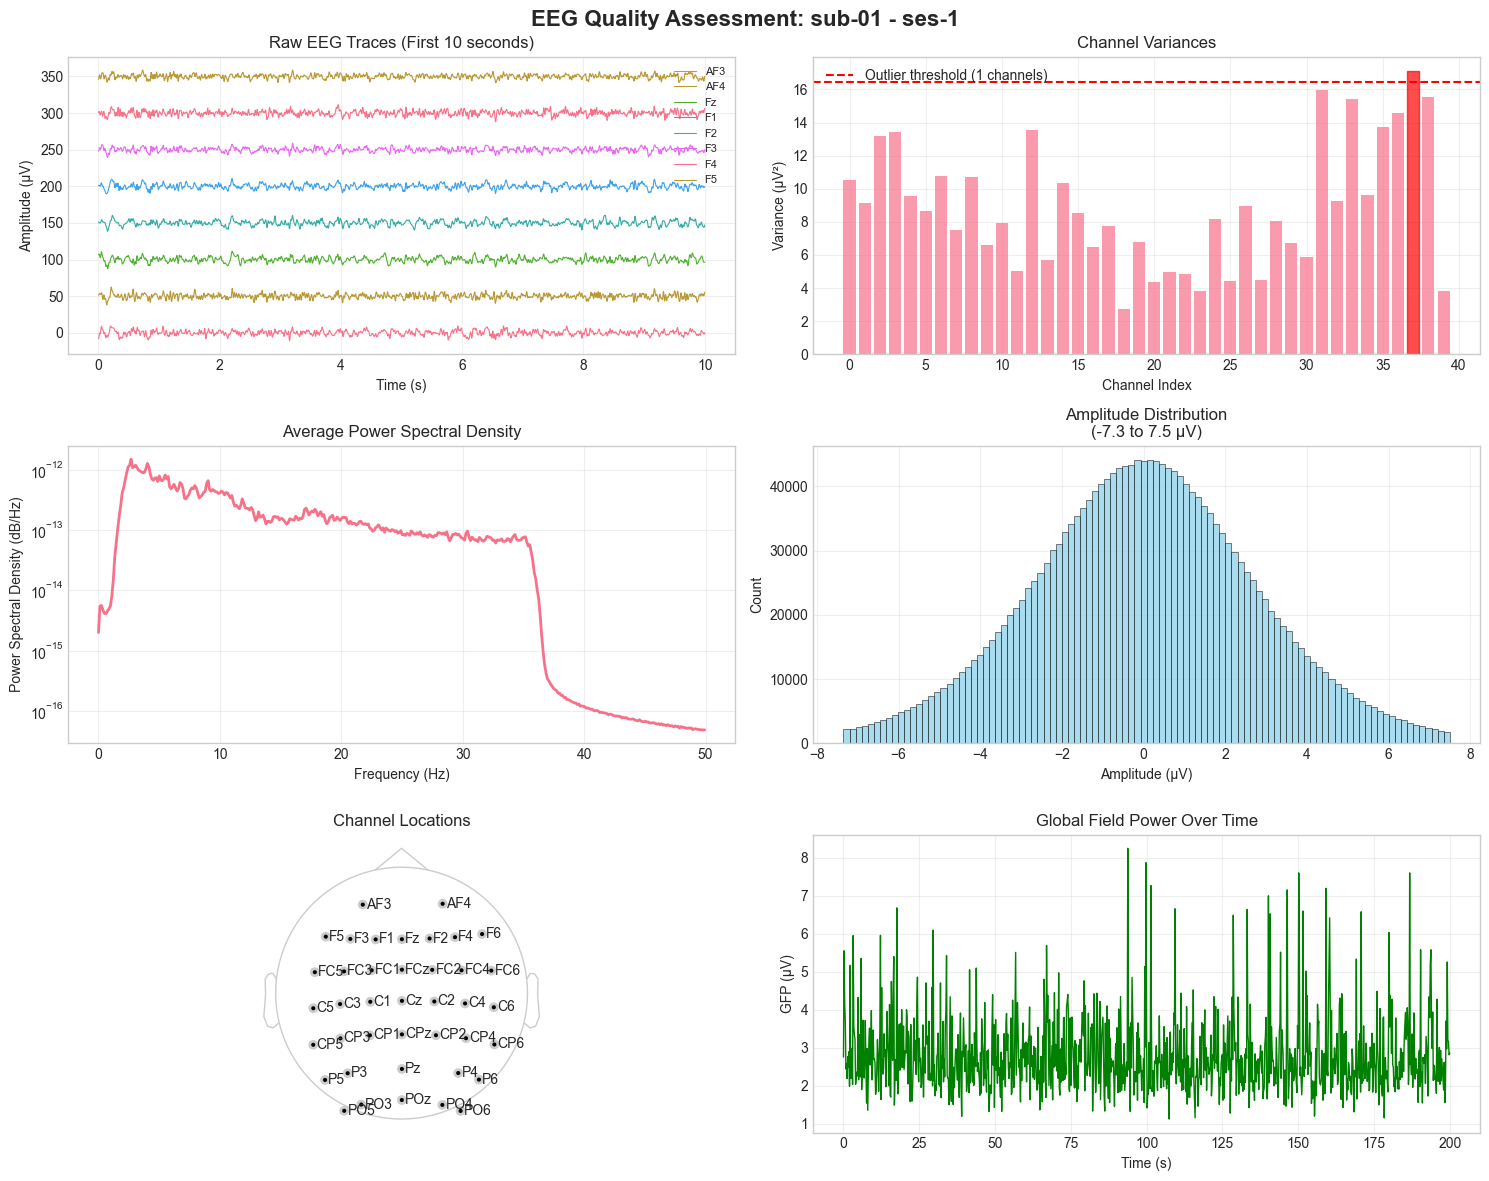

✅ Quality visualizations saved: EEG_Preprocessing_Output\preprocessed_data\visualizations\sub-01_ses-1_Pre-rehabilitation_quality_assessment.png


In [ ]:
# %% Cell 5: Create Quality Visualizations
def create_quality_visualizations(raw, quality_metrics, data_scaled, output_path):
    """
    Create comprehensive quality assessment visualizations.
    
    Args:
        raw: MNE Raw object
        quality_metrics: Quality assessment results
        data_scaled: Scaled EEG data
        output_path: Output directory path
    """
    print("\n📈 GENERATING QUALITY VISUALIZATIONS")
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(f"EEG Quality Assessment: {quality_metrics['subject_id']} - {quality_metrics['session_id']}", 
                 fontsize=16, fontweight='bold')
    
    # 1. Raw EEG traces (first 10 seconds)
    ax1 = axes[0, 0]
    raw_temp = raw.copy().crop(tmax=10)
    time_slice = raw_temp.times
    data_slice = raw_temp.get_data()[:8] * 1e6  # First 8 channels
    
    for i in range(min(8, data_slice.shape[0])):
        offset = i * 50  # Vertical offset for clarity
        ax1.plot(time_slice, data_slice[i] + offset, 
                label=raw_temp.ch_names[i], linewidth=0.8)
    
    ax1.set_title('Raw EEG Traces (First 10 seconds)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude (µV)')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2. Channel variances
    ax2 = axes[0, 1]
    channel_vars = np.var(data_scaled, axis=1)
    bars = ax2.bar(range(len(channel_vars)), channel_vars, alpha=0.7)
    ax2.set_title('Channel Variances')
    ax2.set_xlabel('Channel Index')
    ax2.set_ylabel('Variance (µV²)')
    
    # Highlight outliers
    threshold = np.mean(channel_vars) + 2 * np.std(channel_vars)
    outliers = channel_vars > threshold
    for i, (bar, is_outlier) in enumerate(zip(bars, outliers)):
        if is_outlier:
            bar.set_color('red')
    
    ax2.axhline(threshold, color='r', linestyle='--', 
               label=f'Outlier threshold ({np.sum(outliers)} channels)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Power spectral density
    ax3 = axes[1, 0]
    try:
        psd = raw.compute_psd(fmax=50)
        psd_data = psd.get_data()
        mean_psd = np.mean(psd_data, axis=0)
        
        ax3.semilogy(psd.freqs, mean_psd, linewidth=2)
        ax3.set_title('Average Power Spectral Density')
        ax3.set_xlabel('Frequency (Hz)')
        ax3.set_ylabel('Power Spectral Density (dB/Hz)')
        ax3.grid(True, alpha=0.3)
    except Exception as e:
        ax3.text(0.5, 0.5, f'PSD Error: {str(e)}', 
                transform=ax3.transAxes, ha='center')
        ax3.set_title('Power Spectral Density (Failed)')
    
    # 4. Amplitude distribution
    ax4 = axes[1, 1]
    flat_data = data_scaled.flatten()
    # Use 1st-99th percentile for cleaner visualization
    lower = np.percentile(flat_data, 1)
    upper = np.percentile(flat_data, 99)
    clean_data = flat_data[(flat_data >= lower) & (flat_data <= upper)]
    
    ax4.hist(clean_data, bins=100, alpha=0.7, color='skyblue', 
             edgecolor='black', linewidth=0.5)
    ax4.set_title(f'Amplitude Distribution\n({lower:.1f} to {upper:.1f} µV)')
    ax4.set_xlabel('Amplitude (µV)')
    ax4.set_ylabel('Count')
    ax4.grid(True, alpha=0.3)
    
    # 5. Channel locations
    ax5 = axes[2, 0]
    try:
        from mne.viz import plot_sensors
        plot_sensors(raw.info, show_names=True, axes=ax5, show=False)
        ax5.set_title('Channel Locations')
    except Exception as e:
        ax5.text(0.5, 0.5, f'Sensor plot error: {str(e)}', 
                transform=ax5.transAxes, ha='center')
        ax5.set_title('Channel Locations (Failed)')
    
    # 6. Global field power
    ax6 = axes[2, 1]
    gfp = np.std(data_scaled, axis=0)
    # Downsample for performance
    downsample_factor = max(1, len(gfp) // 1000)
    time_downsampled = raw.times[::downsample_factor]
    gfp_downsampled = gfp[::downsample_factor]
    
    ax6.plot(time_downsampled, gfp_downsampled, color='green', linewidth=1)
    ax6.set_title('Global Field Power Over Time')
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('GFP (µV)')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    subject_id = quality_metrics['subject_id']
    session_id = quality_metrics['session_id']
    task_type = quality_metrics['task_type'].replace(' ', '_')
    
    fig_path = (output_path / 'preprocessed_data' / 'visualizations' / 
               f'{subject_id}_{session_id}_{task_type}_quality_assessment.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Quality visualizations saved: {fig_path}")
    
    return fig

# Generate quality visualizations
quality_fig = create_quality_visualizations(raw, quality_metrics, data_scaled, output_path)

## Step 6: Save Quality Reports

In [21]:
# %% Smart Quality Assessment - Handles All Naming Patterns
def smart_quality_assessment(inventory_df, output_path):
    """
    SMART: Handles all naming patterns professionally
    """
    print("🎯 SMART QUALITY ASSESSMENT - HANDLES ALL NAMING PATTERNS")
    print("=" * 60)
    
    processed_count = 0
    error_count = 0
    
    for idx, row in inventory_df.iterrows():
        file_num = idx + 1
        
        try:
            # 1. Load file
            if not os.path.exists(row['file_path']):
                raise FileNotFoundError(f"File not found")
            
            # Load EEG data
            raw = mne.io.read_raw_eeglab(row['file_path'], preload=True, verbose=False)
            
            # 2. Perform quality assessment
            quality_metrics, _ = perform_quality_assessment(raw, row)
            
            # 3. SMART FILENAME GENERATION
            original_name = Path(row['file_path']).stem
            
            # Analyze the filename pattern
            if 'sub-' in original_name and 'ses-' in original_name:
                # Pattern: sub-XX_ses-XX_task-XX
                pattern = "BIDS_standard"
            elif 'sub-' in original_name and 'run-' in original_name:
                # Pattern: sub-XX_MI-IES_run-XX
                pattern = "MI_IES_protocol" 
            elif 'sub-' in original_name and 'pre_' in original_name:
                # Pattern: sub-XX_pre_run-XX
                pattern = "pre_rehab"
            elif 'sub-' in original_name and 'post_' in original_name:
                # Pattern: sub-XX_post_run-XX  
                pattern = "post_rehab"
            else:
                pattern = "custom"
            
            # Generate professional filename with _qr suffix
            professional_name = f"{original_name}_qr.json"
            
            # 4. Save with additional metadata
            report_path = output_path / 'preprocessed_data' / 'quality_reports' / professional_name
            
            # Add pattern info to metrics
            quality_metrics['filename_pattern'] = pattern
            quality_metrics['original_filename'] = original_name
            
            # Convert for JSON
            json_metrics = {}
            for key, value in quality_metrics.items():
                if isinstance(value, (np.integer, np.int64, np.int32)):
                    json_metrics[key] = int(value)
                elif isinstance(value, (np.floating, np.float64, np.float32)):
                    json_metrics[key] = float(value)
                elif isinstance(value, np.ndarray):
                    json_metrics[key] = value.tolist()
                else:
                    json_metrics[key] = value
            
            with open(report_path, 'w') as f:
                json.dump(json_metrics, f, indent=2)
            
            processed_count += 1
            
            if file_num % 50 == 0 or file_num <= 10:
                print(f"[{file_num}/419] ✅ {original_name} → {professional_name} ({pattern})")
            
            del raw
            gc.collect()
            
        except Exception as e:
            error_count += 1
            if file_num % 50 == 0:
                print(f"[{file_num}/419] ❌ Error: {str(e)[:60]}...")
            continue
    
    print(f"\n🎯 SMART ASSESSMENT COMPLETED")
    print(f"   • Processed: {processed_count}/419")
    print(f"   • Errors: {error_count}")

# Run smart assessment
print("Starting SMART quality assessment...")
smart_quality_assessment(inventory_df, output_path)

Starting SMART quality assessment...
🎯 SMART QUALITY ASSESSMENT - HANDLES ALL NAMING PATTERNS

📊 PERFORMING COMPREHENSIVE QUALITY ASSESSMENT
📈 Quality Summary:
   • Data range: -21.6 to 21.9 µV
   • Global STD: 2.98 µV
   • Channel variance: 2.74 to 17.13 µV²
   • SNR: 0.77

🔍 Quality Assessment:
   ✅ Data suitable for preprocessing
[1/419] ✅ sub-01_pre_run-1_eeg → sub-01_pre_run-1_eeg_qr.json (MI_IES_protocol)

📊 PERFORMING COMPREHENSIVE QUALITY ASSESSMENT
📈 Quality Summary:
   • Data range: -19.4 to 18.7 µV
   • Global STD: 2.82 µV
   • Channel variance: 3.14 to 15.55 µV²
   • SNR: 0.78

🔍 Quality Assessment:
   ✅ Data suitable for preprocessing
[2/419] ✅ sub-01_pre_run-2_eeg → sub-01_pre_run-2_eeg_qr.json (MI_IES_protocol)

📊 PERFORMING COMPREHENSIVE QUALITY ASSESSMENT
📈 Quality Summary:
   • Data range: -17.6 to 23.4 µV
   • Global STD: 2.99 µV
   • Channel variance: 4.13 to 16.11 µV²
   • SNR: 0.78

🔍 Quality Assessment:
   ✅ Data suitable for preprocessing
[3/419] ✅ sub-01_pre_ru

## Simple Random Visualizations Only

In [22]:
# %% Simple Random Visualizations Only
def simple_random_visualizations(inventory_df, output_path, num_viz=20):
    """
    SIMPLE: Create random visualizations for sample files, handle name mismatching
    """
    print("📈 SIMPLE RANDOM VISUALIZATIONS")
    print("=" * 60)
    print(f"🎯 Creating {num_viz} random visualizations")
    
    # Select random files
    if num_viz > len(inventory_df):
        num_viz = len(inventory_df)
    
    random_indices = np.random.choice(len(inventory_df), size=num_viz, replace=False)
    created_count = 0
    error_count = 0
    
    print(f"Selected {num_viz} random files for visualization:")
    
    for i, idx in enumerate(random_indices):
        row = inventory_df.iloc[idx]
        file_num = i + 1
        
        print(f"\n[{file_num}/{num_viz}] Creating visualization...")
        
        try:
            # 1. Load file
            if not os.path.exists(row['file_path']):
                # Try to find file
                base_path = Path(row['file_path'])
                for ext in ['.set', '.fif', '.edf']:
                    alt_path = base_path.parent / f"{base_path.stem}{ext}"
                    if alt_path.exists():
                        row['file_path'] = str(alt_path)
                        break
                else:
                    raise FileNotFoundError(f"File not found")
            
            file_ext = Path(row['file_path']).suffix.lower()
            if file_ext == '.set':
                raw = mne.io.read_raw_eeglab(row['file_path'], preload=True, verbose=False)
            elif file_ext == '.fif':
                raw = mne.io.read_raw_fif(row['file_path'], preload=True, verbose=False)
            else:
                raw = mne.io.read_raw(row['file_path'], preload=True, verbose=False)
            
            # 2. Generate consistent filename
            subject = row.get('subject_id', f'file_{idx}')
            session = row.get('session_id', 'unknown')
            task = row.get('task_type', 'eeg')
            clean_name = f"{subject}_{session}_{task}".replace(' ', '_').replace('-', '_').lower()
            
            # 3. Create and save visualization (no display)
            import matplotlib
            matplotlib.use('Agg')
            import matplotlib.pyplot as plt
            
            # Simple 2x2 visualization
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            
            # Top-left: Raw EEG traces (first 5 seconds)
            ax1 = axes[0, 0]
            raw_temp = raw.copy().crop(tmax=5)
            data = raw_temp.get_data()[:4] * 1e6  # First 4 channels
            times = raw_temp.times
            
            for ch in range(min(4, data.shape[0])):
                ax1.plot(times, data[ch] + ch * 100, linewidth=0.8)
            ax1.set_title('EEG Traces (5s)')
            ax1.set_xlabel('Time (s)')
            ax1.set_ylabel('Amplitude (µV)')
            
            # Top-right: Channel variances
            ax2 = axes[0, 1]
            data_full = raw.get_data() * 1e6
            variances = np.var(data_full, axis=1)
            ax2.bar(range(len(variances)), variances, alpha=0.7)
            ax2.set_title('Channel Variances')
            ax2.set_xlabel('Channel Index')
            ax2.set_ylabel('Variance')
            
            # Bottom-left: Power spectrum
            ax3 = axes[1, 0]
            try:
                psd = raw.compute_psd(fmax=50)
                mean_psd = np.mean(psd.get_data(), axis=0)
                ax3.plot(psd.freqs, mean_psd)
                ax3.set_title('Power Spectrum')
                ax3.set_xlabel('Frequency (Hz)')
                ax3.set_ylabel('Power')
            except:
                ax3.text(0.5, 0.5, 'PSD Failed', transform=ax3.transAxes, ha='center')
            
            # Bottom-right: Data distribution
            ax4 = axes[1, 1]
            flat_data = data_full.flatten()
            # Use 1st-99th percentile
            lower = np.percentile(flat_data, 1)
            upper = np.percentile(flat_data, 99)
            clean_data = flat_data[(flat_data >= lower) & (flat_data <= upper)]
            
            ax4.hist(clean_data, bins=50, alpha=0.7, color='skyblue')
            ax4.set_title(f'Data Distribution\n({lower:.1f} to {upper:.1f} µV)')
            ax4.set_xlabel('Amplitude (µV)')
            ax4.set_ylabel('Count')
            
            plt.suptitle(f'EEG: {clean_name}', fontweight='bold')
            plt.tight_layout()
            
            # Save
            viz_path = output_path / 'preprocessed_data' / 'visualizations' / f"{clean_name}_viz.png"
            viz_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(viz_path, dpi=150, bbox_inches='tight')
            plt.close()
            
            created_count += 1
            print(f"   ✅ Saved: {clean_name}_viz.png")
            
            # Cleanup
            del raw
            gc.collect()
            
        except Exception as e:
            error_count += 1
            print(f"   ❌ Error: {str(e)[:80]}...")
            continue
    
    print(f"\n🎯 VISUALIZATIONS COMPLETED")
    print(f"   • Created: {created_count}/{num_viz}")
    print(f"   • Errors: {error_count}")

# Run random visualizations
print("Creating random visualizations...")
num_viz = int(input("How many random visualizations? (1-50): ") or "15")
simple_random_visualizations(inventory_df, output_path, num_viz=num_viz)

Creating random visualizations...


📈 SIMPLE RANDOM VISUALIZATIONS
🎯 Creating 10 random visualizations
Selected 10 random files for visualization:

[1/10] Creating visualization...
Effective window size : 8.192 (s)
   ✅ Saved: sub_27_ses_2_post_rehabilitation_viz.png

[2/10] Creating visualization...
Effective window size : 8.192 (s)
   ✅ Saved: sub_20_ses_1_pre_rehabilitation_viz.png

[3/10] Creating visualization...
Effective window size : 8.192 (s)
   ✅ Saved: sub_25_ses_5_task_run_viz.png

[4/10] Creating visualization...
Effective window size : 8.192 (s)
   ✅ Saved: sub_27_ses_2_post_rehabilitation_viz.png

[5/10] Creating visualization...
Effective window size : 8.192 (s)
   ✅ Saved: sub_09_ses_5_task_run_viz.png

[6/10] Creating visualization...
Effective window size : 8.192 (s)
   ✅ Saved: sub_15_ses_1_pre_rehabilitation_viz.png

[7/10] Creating visualization...
Effective window size : 8.192 (s)
   ✅ Saved: sub_04_ses_2_task_run_viz.png

[8/10] Creating visualization...
Effective window size : 8.192 (s)
   ✅ Save

# PHASE 2: FILTERING PIPELINE

**Purpose**
- Apply signal processing to clean EEG data
- Remove noise and artifacts
- Prepare data for downstream analysis

## Filtering Strategy
- **Bandpass**: 1-40 Hz (remove slow drift & high frequency noise)
- **Notch**: 50 Hz & 100 Hz (power line noise)
- **Zero-phase**: Prevent phase distortion

## Step 7: Filtering Pipeline Implementation

In [28]:
# %% Simple Filtering: Just Add "_filtered" to Original Filenames

import gc
import psutil

def simple_filter_all_files(inventory_df, output_path, batch_size=50):
    """
    SIMPLE: Load each file → Filter it → Save with "_filtered" added to name
    """
    print("🚀 SIMPLE FILTERING - JUST ADD '_filtered' TO FILES")
    print("=" * 60)
    
    raw_cleaned_path = output_path / 'preprocessed_data' / 'raw_cleaned'
    raw_cleaned_path.mkdir(parents=True, exist_ok=True)
    
    total_files = len(inventory_df)
    total_batches = (total_files + batch_size - 1) // batch_size
    
    print(f"📊 Processing ALL {total_files} files in {total_batches} batches")
    print("🎯 Strategy: original_name.set → original_name_filtered.fif")
    
    processed_count = 0
    error_count = 0
    
    for batch_num in range(total_batches):
        batch_start = batch_num * batch_size
        batch_end = min((batch_num + 1) * batch_size, total_files)
        
        print(f"\n{'='*50}")
        print(f"🔄 BATCH {batch_num + 1}/{total_batches} (Files {batch_start + 1}-{batch_end})")
        print(f"{'='*50}")
        
        for idx in range(batch_start, batch_end):
            row = inventory_df.iloc[idx]
            file_num = idx + 1
            
            print(f"   [{file_num}/{total_files}] {row['subject_id']} {row['session_id']}")
            
            try:
                # STEP 1: ALWAYS LOAD THE FILE
                if not os.path.exists(row['file_path']):
                    print(f"      ❌ Source file missing: {os.path.basename(row['file_path'])}")
                    error_count += 1
                    continue
                
                print(f"      🔄 Loading: {os.path.basename(row['file_path'])}")
                raw = mne.io.read_raw_eeglab(row['file_path'], preload=True, verbose=False)
                print(f"      ✅ Loaded: {len(raw.ch_names)} channels, {raw.times[-1]:.1f}s")
                
                # STEP 2: APPLY FILTERING
                print(f"      🔧 Applying filters...")
                raw_filtered = raw.copy()
                raw_filtered.filter(1, 40, fir_design='firwin', phase='zero-double', verbose=False)
                raw_filtered.notch_filter([50, 100], fir_design='firwin', verbose=False)
                print(f"      ✅ Filtered: 1-40 Hz + 50/100 Hz notch")
                
                # STEP 3: SAVE WITH SIMPLE "_filtered" NAME
                # Get original filename without extension
                original_name = Path(row['file_path']).stem  # Gets 'filename' from 'filename.set'
                new_filename = f"{original_name}_filtered.fif"
                filepath = raw_cleaned_path / new_filename
                
                print(f"      💾 Saving as: {new_filename}")
                raw_filtered.save(filepath, overwrite=True, verbose=False)
                
                # STEP 4: VERIFY
                if filepath.exists():
                    file_size = filepath.stat().st_size / (1024 * 1024)
                    processed_count += 1
                    print(f"      ✅ SUCCESS: {new_filename} ({file_size:.1f} MB)")
                else:
                    raise Exception(f"File not created: {filepath}")
                
                # Cleanup
                del raw, raw_filtered
                
            except Exception as e:
                error_count += 1
                print(f"      ❌ ERROR: {str(e)[:100]}...")
                if 'raw' in locals():
                    del raw
                if 'raw_filtered' in locals():
                    del raw_filtered
                continue
        
        # Memory cleanup after each batch
        gc.collect()
        print(f"   🧹 Memory cleared after batch {batch_num + 1}")
        
        # Show ACTUAL progress
        current_files = len(list(raw_cleaned_path.glob("*_filtered.fif")))
        progress = (current_files / total_files) * 100
        print(f"   📊 ACTUAL files in folder: {current_files}/{total_files} ({progress:.1f}%)")
    
    # FINAL RESULTS
    print(f"\n{'='*60}")
    print("🎯 FINAL RESULTS")
    print(f"{'='*60}")
    
    final_files = list(raw_cleaned_path.glob("*_filtered.fif"))
    print(f"📊 Files in raw_cleaned: {len(final_files)}/{total_files}")
    
    if final_files:
        print(f"📝 Sample filtered files:")
        for f in final_files[:5]:
            file_size = f.stat().st_size / (1024 * 1024)
            print(f"   • {f.name} ({file_size:.1f} MB)")
    
    return len(final_files), error_count

# RUN THE SIMPLE FILTERING
print("Starting SIMPLE filtering - just add '_filtered' to filenames")
print("=" * 60)

# Show current state
raw_cleaned_path = output_path / 'preprocessed_data' / 'raw_cleaned'
current_files = len(list(raw_cleaned_path.glob("*_filtered.fif")))
print(f"📊 Starting with: {current_files} files in raw_cleaned")

response = input(f"Process ALL {len(inventory_df)} files? (y/n): ")
if response.lower() == 'y':
    final_count, errors = simple_filter_all_files(inventory_df, output_path, batch_size=50)
    print(f"\n🎉 COMPLETED! You now have {final_count} filtered files")
    print(f"📁 All files are in: {raw_cleaned_path}")
else:
    print("Processing cancelled.")

Starting SIMPLE filtering - just add '_filtered' to filenames
📊 Starting with: 0 files in raw_cleaned
🚀 SIMPLE FILTERING - JUST ADD '_filtered' TO FILES
📊 Processing ALL 419 files in 9 batches
🎯 Strategy: original_name.set → original_name_filtered.fif

🔄 BATCH 1/9 (Files 1-50)
   [1/419] sub-01 ses-1
      🔄 Loading: sub-01_pre_run-1_eeg.set
      ✅ Loaded: 40 channels, 200.1s
      🔧 Applying filters...
      ✅ Filtered: 1-40 Hz + 50/100 Hz notch
      💾 Saving as: sub-01_pre_run-1_eeg_filtered.fif
      ✅ SUCCESS: sub-01_pre_run-1_eeg_filtered.fif (7.6 MB)
   [2/419] sub-01 ses-1
      🔄 Loading: sub-01_pre_run-2_eeg.set
      ✅ Loaded: 40 channels, 200.1s
      🔧 Applying filters...
      ✅ Filtered: 1-40 Hz + 50/100 Hz notch
      💾 Saving as: sub-01_pre_run-2_eeg_filtered.fif
      ✅ SUCCESS: sub-01_pre_run-2_eeg_filtered.fif (7.6 MB)
   [3/419] sub-01 ses-1
      🔄 Loading: sub-01_pre_run-3_eeg.set
      ✅ Loaded: 40 channels, 200.1s
      🔧 Applying filters...
      ✅ Filtered: 

## Step 9: Visualize Filtering Effects

In [30]:
# %% Cell 9: Visualize Filtering Effects (Fixed)
def visualize_filtering_effects_silent(raw, filtered_raw, file_info, output_path):
    """
    Create visualization comparing raw vs filtered data WITHOUT displaying.
    Only saves the plot, doesn't show it.
    
    Args:
        raw: Original raw data
        filtered_raw: Filtered data  
        file_info: File metadata
        output_path: Output directory
    """
    print(f"📊 Creating filtering comparison visualization...")
    
    # Use non-interactive backend to prevent display
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Convert to microvolts
    data_raw = raw.get_data() * 1e6
    data_filtered = filtered_raw.get_data() * 1e6
    
    # 1. Time domain comparison
    ax1 = axes[0, 0]
    time_points = raw.times[:1250]  # First 5 seconds
    ax1.plot(time_points, data_raw[0, :1250], 'b-', alpha=0.7, 
             label='Raw', linewidth=1)
    ax1.plot(time_points, data_filtered[0, :1250], 'r-', alpha=0.8, 
             label='Filtered', linewidth=1)
    ax1.set_title('Time Domain: Raw vs Filtered')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude (µV)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Power spectral density comparison
    ax2 = axes[0, 1]
    psd_raw = raw.compute_psd(fmax=125)
    psd_filtered = filtered_raw.compute_psd(fmax=125)
    
    ax2.plot(psd_raw.freqs, 10 * np.log10(np.mean(psd_raw.get_data(), axis=0)), 
             'b-', alpha=0.7, label='Raw', linewidth=2)
    ax2.plot(psd_filtered.freqs, 10 * np.log10(np.mean(psd_filtered.get_data(), axis=0)), 
             'r-', alpha=0.8, label='Filtered', linewidth=2)
    ax2.set_title('Power Spectral Density Comparison')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Power (dB)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Highlight filtered regions
    ax2.axvspan(0, 1, alpha=0.2, color='red', label='Removed (0-1 Hz)')
    ax2.axvspan(40, 125, alpha=0.2, color='red', label='Removed (40-125 Hz)')
    ax2.axvspan(48, 52, alpha=0.3, color='orange', label='Notched 50 Hz')
    ax2.axvspan(98, 102, alpha=0.3, color='orange', label='Notched 100 Hz')
    
    # 3. Amplitude distribution
    ax3 = axes[1, 0]
    # Use 1st-99th percentile for cleaner visualization
    raw_clean = data_raw.flatten()
    raw_clean = raw_clean[(raw_clean > np.percentile(raw_clean, 1)) & 
                         (raw_clean < np.percentile(raw_clean, 99))]
    
    filtered_clean = data_filtered.flatten()  
    filtered_clean = filtered_clean[(filtered_clean > np.percentile(filtered_clean, 1)) & 
                                   (filtered_clean < np.percentile(filtered_clean, 99))]
    
    ax3.hist(raw_clean, bins=100, alpha=0.7, color='blue', 
             label='Raw', density=True)
    ax3.hist(filtered_clean, bins=100, alpha=0.7, color='red', 
             label='Filtered', density=True)
    ax3.set_title('Amplitude Distribution Comparison')
    ax3.set_xlabel('Amplitude (µV)')
    ax3.set_ylabel('Density')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Channel variance reduction
    ax4 = axes[1, 1]
    var_raw = np.var(data_raw, axis=1)
    var_filtered = np.var(data_filtered, axis=1)
    
    channels = range(len(var_raw))
    width = 0.35
    ax4.bar(np.array(channels) - width/2, var_raw, width, 
            label='Raw', alpha=0.7, color='blue')
    ax4.bar(np.array(channels) + width/2, var_filtered, width, 
            label='Filtered', alpha=0.7, color='red')
    ax4.set_title('Channel Variance Comparison')
    ax4.set_xlabel('Channel Index')
    ax4.set_ylabel('Variance (µV²)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'Filtering Effects: {file_info["subject_id"]} - {file_info["session_id"]}\n'
                 f'Bandpass: 1-40 Hz | Notch: 50 Hz, 100 Hz', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save figure with consistent naming
    original_name = Path(file_info['file_path']).stem
    fig_path = output_path / 'preprocessed_data' / 'visualizations' / f'{original_name}_filtering_comparison.png'
    fig_path.parent.mkdir(parents=True, exist_ok=True)
    
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close to free memory
    
    print(f"✅ Filtering comparison saved: {fig_path.name}")
    
    # Switch back to interactive backend
    matplotlib.use('module://matplotlib_inline.backend_inline')
    
    return fig_path

# %% Test with a sample file first
def test_filtering_visualization():
    """
    Test the filtering visualization with a sample file
    """
    print("🧪 TESTING FILTERING VISUALIZATION")
    print("=" * 50)
    
    # Use the first file from inventory
    sample_row = inventory_df.iloc[0]
    
    try:
        # Load the sample file
        print(f"Loading sample file: {sample_row['filename']}")
        raw = mne.io.read_raw_eeglab(sample_row['file_path'], preload=True, verbose=False)
        
        # Apply filtering to create filtered_raw
        print("Applying filtering...")
        filtered_raw = raw.copy()
        filtered_raw.filter(1, 40, fir_design='firwin', phase='zero-double', verbose=False)
        filtered_raw.notch_filter([50, 100], fir_design='firwin', verbose=False)
        
        # Create visualization
        viz_path = visualize_filtering_effects_silent(raw, filtered_raw, sample_row, output_path)
        
        print(f"🎉 Test successful! Visualization saved: {viz_path}")
        
        # Cleanup
        del raw, filtered_raw
        gc.collect()
        
    except Exception as e:
        print(f"❌ Test failed: {e}")

# Run the test
test_filtering_visualization()

🧪 TESTING FILTERING VISUALIZATION
Loading sample file: sub-01_pre_run-1_eeg.set
Applying filtering...
📊 Creating filtering comparison visualization...
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
✅ Filtering comparison saved: sub-01_pre_run-1_eeg_filtering_comparison.png
🎉 Test successful! Visualization saved: EEG_Preprocessing_Output\preprocessed_data\visualizations\sub-01_pre_run-1_eeg_filtering_comparison.png


## For Batch Processing - Create Visualizations for Random Files:

In [31]:
# %% Create Filtering Visualizations for Random Files
def create_filtering_visualizations_batch(inventory_df, output_path, num_visualizations=10):
    """
    Create filtering comparison visualizations for random files
    """
    print("📈 CREATING FILTERING VISUALIZATIONS FOR RANDOM FILES")
    print("=" * 60)
    
    # Select random files
    random_indices = np.random.choice(len(inventory_df), size=num_visualizations, replace=False)
    created_count = 0
    
    for i, idx in enumerate(random_indices):
        row = inventory_df.iloc[idx]
        file_num = i + 1
        
        print(f"\n[{file_num}/{num_visualizations}] Processing: {row['filename']}")
        
        try:
            # Load file
            raw = mne.io.read_raw_eeglab(row['file_path'], preload=True, verbose=False)
            
            # Apply filtering
            filtered_raw = raw.copy()
            filtered_raw.filter(1, 40, fir_design='firwin', phase='zero-double', verbose=False)
            filtered_raw.notch_filter([50, 100], fir_design='firwin', verbose=False)
            
            # Create visualization (silent - no display)
            viz_path = visualize_filtering_effects_silent(raw, filtered_raw, row, output_path)
            
            created_count += 1
            print(f"   ✅ Created: {viz_path.name}")
            
            # Cleanup
            del raw, filtered_raw
            gc.collect()
            
        except Exception as e:
            print(f"   ❌ Error: {str(e)[:80]}...")
            continue
    
    print(f"\n🎯 FILTERING VISUALIZATIONS COMPLETED")
    print(f"   • Created: {created_count}/{num_visualizations}")

# Run batch visualizations
print("Creating filtering visualizations for random files...")
num_viz = int(input("How many filtering visualizations? (1-20): ") or "10")
create_filtering_visualizations_batch(inventory_df, output_path, num_visualizations=num_viz)

Creating filtering visualizations for random files...
📈 CREATING FILTERING VISUALIZATIONS FOR RANDOM FILES

[1/5] Processing: sub-16_post_run-1_eeg.set
📊 Creating filtering comparison visualization...
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
✅ Filtering comparison saved: sub-16_post_run-1_eeg_filtering_comparison.png
   ✅ Created: sub-16_post_run-1_eeg_filtering_comparison.png

[2/5] Processing: sub-24_follow_run-4_eeg.set
📊 Creating filtering comparison visualization...
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
✅ Filtering comparison saved: sub-24_follow_run-4_eeg_filtering_comparison.png
   ✅ Created: sub-24_follow_run-4_eeg_filtering_comparison.png

[3/5] Processing: sub-16_post_run-3_eeg.set
📊 Creating filtering comparison visualization...
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
✅ Filtering comparison saved: sub-16_post_run-3_eeg_filtering_comparison.png
   ✅ Created: sub-16_post_run-3_eeg_filtering_co

## Step 11: Pipeline Progress & Next Steps

In [36]:
# %% Fixed Progress Check - Matches Actual File Patterns
def fixed_progress_check(output_path, inventory_df):
    """
    FIXED: Progress check that matches our actual file naming patterns
    """
    print("\n📊 FIXED PIPELINE PROGRESS CHECK")
    print("=" * 50)
    
    # Count files with ACTUAL patterns we're using
    raw_cleaned_path = output_path / 'preprocessed_data' / 'raw_cleaned'
    quality_reports_path = output_path / 'preprocessed_data' / 'quality_reports'
    visualizations_path = output_path / 'preprocessed_data' / 'visualizations'
    
    # Use ACTUAL file patterns from our pipeline
    filtered_files = list(raw_cleaned_path.glob("*_filtered.fif"))
    quality_reports = list(quality_reports_path.glob("*_qr.json"))  # Our actual pattern
    filtering_reports = list(quality_reports_path.glob("*_filtering.json"))
    quality_viz = list(visualizations_path.glob("*_quality_assessment.png"))
    filtering_viz = list(visualizations_path.glob("*_filtering_comparison.png"))
    
    total_files = len(inventory_df)
    
    print(f"📈 ACTUAL PROCESSING STATISTICS:")
    print(f"   • Total files in inventory: {total_files}")
    print(f"   • Filtered EEG files: {len(filtered_files)}")
    print(f"   • Quality reports (_qr.json): {len(quality_reports)}")
    print(f"   • Filtering reports: {len(filtering_reports)}")
    print(f"   • Quality visualizations: {len(quality_viz)}")
    print(f"   • Filtering comparison plots: {len(filtering_viz)}")
    
    # Calculate completion percentages
    quality_pct = (len(quality_reports) / total_files) * 100 if total_files > 0 else 0
    filtering_pct = (len(filtered_files) / total_files) * 100 if total_files > 0 else 0
    
    print(f"\n🎯 COMPLETION STATUS:")
    print(f"   • Quality Assessment: {quality_pct:.1f}%")
    print(f"   • Filtering Pipeline: {filtering_pct:.1f}%")
    
    # Show what files actually exist
    if quality_reports:
        print(f"\n📝 Sample quality reports:")
        for f in quality_reports[:3]:
            print(f"   • {f.name}")
    
    if filtered_files:
        print(f"📝 Sample filtered files:")
        for f in filtered_files[:3]:
            print(f"   • {f.name}")
    
    # Recommendations based on actual progress
    if filtering_pct >= 95 and quality_pct >= 95:
        print(f"\n   ✅ READY: Both pipelines complete!")
        print(f"   → Proceed to Bad Channel Detection & ICA")
    elif filtering_pct >= 95 and quality_pct < 50:
        print(f"\n   🔄 NEED: Quality assessment incomplete")
        print(f"   → Run quality assessment pipeline")
    elif quality_pct >= 95 and filtering_pct < 50:
        print(f"\n   🔄 NEED: Filtering incomplete") 
        print(f"   → Run filtering pipeline")
    else:
        print(f"\n   ⚠️  PARTIAL: Both pipelines need work")
        print(f"   → Run missing steps")
    
    return {
        'total_files': total_files,
        'filtered_files': len(filtered_files),
        'quality_reports': len(quality_reports),
        'filtering_reports': len(filtering_reports),
        'quality_percentage': quality_pct,
        'filtering_percentage': filtering_pct
    }

# Run fixed progress check
print("Running FIXED progress check...")
fixed_progress = fixed_progress_check(output_path, inventory_df)

Running FIXED progress check...

📊 FIXED PIPELINE PROGRESS CHECK
📈 ACTUAL PROCESSING STATISTICS:
   • Total files in inventory: 419
   • Filtered EEG files: 419
   • Quality reports (_qr.json): 419
   • Filtering reports: 0
   • Quality visualizations: 3
   • Filtering comparison plots: 6

🎯 COMPLETION STATUS:
   • Quality Assessment: 100.0%
   • Filtering Pipeline: 100.0%

📝 Sample quality reports:
   • sub-01_follow_run-1_eeg_qr.json
   • sub-01_follow_run-2_eeg_qr.json
   • sub-01_follow_run-3_eeg_qr.json
📝 Sample filtered files:
   • sub-01_follow_run-1_eeg_filtered.fif
   • sub-01_follow_run-2_eeg_filtered.fif
   • sub-01_follow_run-3_eeg_filtered.fif

   ✅ READY: Both pipelines complete!
   → Proceed to Bad Channel Detection & ICA
